# Model Architecture

```
RGB ----> RGB Encoder ----\
                            ----> Fusion ---> Classifier ---> cube/sphere
LiDAR -> LiDAR Encoder ----/
```



**The Architecture Flow:**

```
RGB Input (4ch)       LiDAR Input (4ch)
      │                     │
[RGB Encoder]         [XYZ Encoder]    <-- Learn specific features independently
      │                     │
  RGB Features          XYZ Features   <-- (e.g. 128 channels each)
      └──────────┬──────────┘
                 │
           Concatenation               <-- Fuse at the "Feature Level"
                 │
         [Regression Head]             <-- Learn relationships between features
                 │
           Output (x,y,z)
```

Multimodal fusion refers to how we combine information from different modalities (e.g., RGB and LiDAR).
There are three canonical levels of fusion:

Early fusion – combine raw or early-level features

Intermediate fusion – combine learned feature representations

Late fusion – combine decisions or latent vectors at the end of the pipeline;  it's almost like we're creating an ensemble model, where each model has a weighted vote in the final result.

Each level has different strengths + limitations.

# Setup

## Installations & Imports

In [11]:
%%capture
%pip install wandb weave

In [12]:
%%capture
%pip install fiftyone==1.10.0 sympy==1.12 torch==2.9.0 torchvision==0.20.0 numpy open-clip-torch

In [13]:
import os
from pathlib import Path
from google.colab import userdata
import time

from PIL import Image
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

import wandb
import cv2
import albumentations as A

## Storage

In [14]:
## stays - ggf. wo gebraucht

from google.colab import drive
drive.mount('/content/drive')

STORAGE_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Applied Computer Vision/Applied-Computer-Vision-Projects/Multimodal_Learning_02/")

DATA_PATH = STORAGE_PATH / "multimodal_training_workshop/data"
print(f"Data path: {DATA_PATH}")
print(f"Data path exists: {DATA_PATH.exists()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data path: /content/drive/MyDrive/Colab Notebooks/Applied Computer Vision/Applied-Computer-Vision-Projects/Multimodal_Learning_02/multimodal_training_workshop/data
Data path exists: True


In [15]:
# !rsync -ah --progress "/content/drive/MyDrive/Colab Notebooks/Applied Computer Vision/Applied-Computer-Vision-Projects/Multimodal_Learning_02/data" "/content/data/"


In [16]:
## stays

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available()

True

## Constants

In [17]:
## stays

SEED = 51
NUM_WORKERS = os.cpu_count()  # Number of CPU cores

BATCH_SIZE = 32
IMG_SIZE = 64

CLASSES = ["cubes", "spheres"]
NUM_CLASSES = len(CLASSES)
LABEL_MAP = {"cubes": 0, "spheres": 1}

VALID_BATCHES = 10
N = 12500
EPOCHS = 15
LR = 0.0001

# Integration of Wandb

In [18]:
## stays

# Load W&B API key from Colab Secrets and make it available as env variable
wandb_key = userdata.get('WANDB_API_KEY')
os.environ["WANDB_API_KEY"] = wandb_key
wandb.login()

True

In [19]:
## move: training.py

def init_wandb(model, fusion_name, num_params, opt_name, batch_size=BATCH_SIZE, epochs=15):
  """
  Initialize a Weights & Biases run for a given fusion model.

  Args:
      model (nn.Module): The PyTorch model to track.
      fusion_name (str): Short name of the fusion strategy (e.g. "early_fusion").
      num_params (int): Total number of trainable parameters of the model.
      opt_name (str): Name of the optimizer (e.g. "Adam").
      batch_size (int, optional): Batch size used during training.
      epochs (int, optional): Number of training epochs.

  Returns:
      wandb.sdk.wandb_run.Run: The initialized W&B run object.
  """

  config = {
    # "embedding_size": embedding_size,      ## TODO: ändert die sich? hab ich die bei fusion?
    "optimizer_type": opt_name,
    "fusion_strategy": fusion_name,
    "model_architecture": model.__class__.__name__,
    "batch_size": batch_size,
    "num_epochs": epochs,
    "num_parameters": num_params
  }

  run = wandb.init(
    project="cilp-extended-assessment",
    name=f"{fusion_name}_run",
    config=config,
    reinit='finish_previous',                           # allows starting a new run inside one script
  )

  return run

# Utility Functions

alle in utility.py reinschieben



In [20]:
def set_seeds(seed=SEED):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # OpenCV
    cv2.setRNGSeed(seed)

    # Albumentations (for data augmentation)
    try:
        A.seed_everything(seed)
    except AttributeError:
        # Older versions of albumentations
        pass

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")



# Usage: Call this function at the beginning and before each training phase
set_seeds(SEED)

# Additional reproducibility considerations:

def create_deterministic_training_dataloader(dataset, batch_size, shuffle=True, **kwargs):
    """
    Create a DataLoader with deterministic shuffling behaviour.

    Args:
        dataset (Dataset): PyTorch Dataset instance.
        batch_size (int): Batch size.
        shuffle (bool): Whether to shuffle data.
        **kwargs: Additional DataLoader keyword arguments.

    Returns:
        DataLoader: Training DataLoader with reproducible sampling.
    """
    # Use a generator with fixed seed for reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(SEED)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=generator if shuffle else None,
        **kwargs
    )



All random seeds set to 51 for reproducibility


In [21]:
def format_time(seconds):
    """
    Convert a duration in seconds to a human-readable 'MMm SSs' string.

    Args:
        seconds (float): Duration in seconds.

    Returns:
        str: Formatted duration, e.g. "02m 15s".
    """
    m = int(seconds // 60)
    s = int(seconds % 60)
    return f"{m:02d}m {s:02d}s"

In [22]:
def get_torch_xyza(lidar_depth, azimuth, zenith):
    """
    Convert LiDAR depth + angular coordinates into an XYZA tensor.

    Args:
        lidar_depth (torch.Tensor): Radial distances of shape (H, W).
        azimuth (torch.Tensor): Azimuth angles in radians, shape (H,).
        zenith (torch.Tensor): Zenith angles in radians, shape (W,).

    Returns:
        torch.Tensor: Stacked tensor of shape (4, H, W) containing
            X, Y, Z coordinates and a validity mask A.
    """
    # Broadcast azimuth (per row) and zenith (per column) to full image grid
    # and convert polar coordinates into Cartesian coordinates.
    x = lidar_depth * torch.sin(-azimuth[:, None]) * torch.cos(-zenith[None, :])
    y = lidar_depth * torch.cos(-azimuth[:, None]) * torch.cos(-zenith[None, :])
    z = lidar_depth * torch.sin(-zenith[None, :])

    # A is a binary mask: 1 for valid points, 0 for "no return" / far-away
    a = torch.where(lidar_depth < 50.0,
                    torch.ones_like(lidar_depth),
                    torch.zeros_like(lidar_depth))

    xyza = torch.stack([x, y, z, a], dim=0)
    return xyza

In [23]:
def format_positions(positions):
    """
    Format a sequence of numerical positions as nicely aligned strings.

    Args:
        positions (Iterable[float]): Sequence of scalar values.

    Returns:
        list[str]: List of strings with 4 decimal places.
    """
    return ['{0: .4f}'.format(x) for x in positions]

In [24]:
def create_subset(size, dataset):
    """
    Create a random subset of a given dataset.

    Args:
        size (int): Desired number of samples in the subset.
        dataset (torch.utils.data.Dataset): Dataset to sample from.

    Returns:
        torch.utils.data.Subset: Random subset of the given dataset.
    """
    # Sample unique indices uniformly at random from the dataset
    indices = np.random.choice(size, size=size, replace=False)
    return Subset(dataset, indices)

In [25]:
def print_loss(epoch, loss, outputs, target, is_train=True, is_debug=False):
    """
    Print a formatted loss line and optionally one example prediction.

    Args:
        epoch (int): Current epoch index.
        loss (float or Tensor): Loss value for this epoch.
        outputs (torch.Tensor): Model predictions for the current batch.
        target (torch.Tensor): Ground-truth targets for the current batch.
        is_train (bool): If True, label as training loss; else validation.
        is_debug (bool): If True, also print one prediction/target pair.
    """

    loss_type = "train loss:" if is_train else "valid loss:"
    print("epoch", str(epoch), loss_type, str(loss))

    if is_debug:
        print("example pred:", format_positions(outputs[0].tolist()))
        print("example real:", format_positions(target[0].tolist()))

In [26]:
## Final: löschen
## move: visualization.py

def plot_losses(losses, title="Training & Validation Loss Comparison", figsize=(10,6)):
    """
    Legacy plotting helper to show train/valid losses for multiple models.

    Args:
        losses (dict): Mapping model_name -> {"train_losses": [...],
                                              "valid_losses": [...]}.
        title (str): Plot title.
        figsize (tuple): Matplotlib figure size.
    """
    plt.figure(figsize=figsize)

    for model_name, log in losses.items():
        train = log["train_losses"]
        valid = log["valid_losses"]

        # plot train + valid with different line styles
        plt.plot(train, label=f"{model_name} - train", linewidth=2)
        plt.plot(valid, label=f"{model_name} - valid", linestyle="--", linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Loading and preparation of Data

In [29]:
class AssessmentXYZADataset(Dataset):
    """
    Fully preprocessed dataset:

    - Loads raw RGB + depth
    - Loads azimuth/zenith per class
    - Converts depth → XYZA ONCE
    - Applies transform_rgb ONCE
    - Applies transform_lidar ONCE
    - Caches everything in memory

    Then __getitem__ is extremely fast.
    """
    def __init__(
        self,
        root_dir,
        start_idx=0,
        end_idx=None,
        transform_rgb=None,
        transform_lidar=None,
        shuffle=True,
    ):
        self.root_dir = Path(root_dir)

        # These MUST be deterministic transforms (Resize, ToTensor, Normalize...)
        self.transform_rgb = transform_rgb
        self.transform_lidar = transform_lidar

        self.classes = ["cubes", "spheres"]
        self.label_map = {"cubes": 0, "spheres": 1}

        samples = []
        self.az = {}
        self.ze = {}

        print(f"Scanning RAW dataset in {root_dir}...")

        # -------- 1. Scan the dataset & load azimuth/zenith --------
        for cls in self.classes:
            cls_dir   = self.root_dir / cls
            rgb_dir   = cls_dir / "rgb"
            lidar_dir = cls_dir / "lidar"

            # load az/zen
            az_path = cls_dir / "azimuth.npy"
            ze_path = cls_dir / "zenith.npy"
            if not az_path.exists() or not ze_path.exists():
                raise FileNotFoundError(f"Missing azimuth/zenith in {cls_dir}")

            self.az[cls] = torch.from_numpy(np.load(az_path)).float()
            self.ze[cls] = torch.from_numpy(np.load(ze_path)).float()

            # match stems
            rgb_files   = sorted(rgb_dir.glob("*.png"))
            lidar_files = sorted(lidar_dir.glob("*.npy"))

            rgb_stems   = {f.stem for f in rgb_files}
            lidar_stems = {f.stem for f in lidar_files}
            matching    = sorted(rgb_stems & lidar_stems)

            print(f"{cls}: {len(matching)} paired samples")

            for stem in matching:
                samples.append(
                    {
                        "class": cls,
                        "rgb_path": rgb_dir / f"{stem}.png",
                        "depth_path": lidar_dir / f"{stem}.npy",
                        "label": self.label_map[cls],
                    }
                )

        # -------- Optional shuffle --------
        if shuffle:
            rng = random.Random(SEED)
            rng.shuffle(samples)

        if end_idx is None:
            end_idx = len(samples)
        self.samples = samples[start_idx:end_idx]

        # Prepare storage
        self.rgb_tensors = []
        self.lidar_tensors = []
        self.labels = []

        # -------- 2. PRECOMPUTE EVERYTHING --------
        print("Precomputing RGB + XYZA tensors into RAM...")

        for item in tqdm(self.samples, desc="Preprocessing"):
            cls = item["class"]
            az  = self.az[cls]
            ze  = self.ze[cls]

            # --- RGB ---
            rgb_img = Image.open(item["rgb_path"])
            if self.transform_rgb:
                rgb_tensor = self.transform_rgb(rgb_img)  # applied once
            else:
                rgb_tensor = transforms.ToTensor()(rgb_img)

            # --- LiDAR XYZA ---
            depth_np = np.load(item["depth_path"])
            depth_t  = torch.from_numpy(depth_np).float()
            xyza = get_torch_xyza(depth_t, az, ze)        # (4,H,W)

            if self.transform_lidar:
                xyza = self.transform_lidar(xyza)        # applied once

            self.rgb_tensors.append(rgb_tensor)
            self.lidar_tensors.append(xyza)
            self.labels.append(item["label"])

        print(f"Dataset ready: {len(self.samples)} samples preprocessed.")

    # -------- Fast loaders --------
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return (
            self.rgb_tensors[idx],
            self.lidar_tensors[idx],
            torch.tensor(self.labels[idx], dtype=torch.long),
        )


In [20]:
## move: datasets.py

def compute_dataset_mean_std(root_dir):
    """
    Estimate the per-channel mean and std for the RGB+LiDAR data.

    Args:
        root_dir (str or Path): Root directory passed to AssessmentXYZADataset.

    Returns:
        tuple[torch.Tensor, torch.Tensor]:
            mean and std tensors with shape (C,).
    """

    stats_transforms = transforms.Compose([
      transforms.Resize(IMG_SIZE),
      transforms.ToImage(),
      transforms.ToDtype(torch.float32, scale=True),  # [0,1], 4 channels
    ])

    stats_dataset = AssessmentXYZADataset(
        root_dir=root_dir,
        start_idx=0,
        end_idx=None,          # or e.g. 1000 to subsample
        transform_rgb=stats_transforms,
    )

    subset_size = min(2000, len(stats_dataset)*0.3)
    subset_for_stats = create_subset(size=subset_size)

    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

    mean = 0.
    std = 0.
    total = 0

    for images, _, _ in tqdm(loader, desc="Computing mean/std"):
        images = images.float()       # B, C, H, W
        batch_size = images.size(0)

        # compute mean over batch (channels only!)
        mean += images.mean(dim=[0, 2, 3]) * batch_size

        # compute std over batch
        std += images.std(dim=[0, 2, 3]) * batch_size

        total += batch_size

    mean /= total
    std /= total

    return mean, std


In [21]:
def compute_dataset_mean_std_neu(root_dir):
    """
    Estimate the per-channel mean and std for the RGB+LiDAR data.

    Args:
        root_dir (str or Path): Root directory passed to AssessmentXYZADataset.

    Returns:
        tuple[torch.Tensor, torch.Tensor]:
            mean and std tensors with shape (C,).
    """
    stats_transforms = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),  # [0,1], 4 channels
    ])

    stats_dataset = AssessmentXYZADataset(
        root_dir=root_dir,
        transform_rgb=stats_transforms,
        transform_lidar=None,
        shuffle=False,
    )

    loader = DataLoader(stats_dataset, batch_size=64, shuffle=False)

    # Accumulate running sum and sum of squares to compute mean/std
    channel_sum = torch.zeros(4)
    channel_sq_sum = torch.zeros(4)
    num_pixels = 0

    for rgb, _, _ in tqdm(loader, desc="Computing mean/std"):
        # rgb shape: (B, C, H, W)
        b, c, h, w = rgb.shape
        num_pixels += b * h * w
        channel_sum += rgb.sum(dim=[0, 2, 3])
        channel_sq_sum += (rgb ** 2).sum(dim=[0, 2, 3])

    mean = channel_sum / num_pixels
    std = torch.sqrt(channel_sq_sum / num_pixels - mean ** 2)
    return mean, std


In [22]:
## Final: dynamisch
#root = STORAGE_PATH / "data"
#mean, std = compute_dataset_mean_std(root_dir=root)

In [30]:
## Final: dynamisch
img_transforms = transforms.Compose([
    transforms.ToImage(),   # Scales data into [0,1]
    transforms.Resize(IMG_SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(([0.0051, 0.0052, 0.0051, 1.0000]), ([5.8023e-02, 5.8933e-02, 5.8108e-02, 2.4509e-07]))     ## assessment dataset
    # transforms.Normalize(mean.tolist(), std.tolist())     ## assessment dataset
])

In [31]:
def get_dataloaders(root_dir, test_frac=0.2):
    """
    Create train / val / test datasets + dataloaders.

    - Validation set has exactly VALID_BATCHES * BATCH_SIZE samples.
    - Validation DataLoader with drop_last=True → exactly VALID_BATCHES batches.
    - Train/test share the remaining samples via a random split.
    """

    # 1) Base dataset: no internal shuffle, full range
    base_dataset = AssessmentXYZADataset(
        root_dir,
        start_idx=0,
        end_idx=None,
        transform_rgb=img_transforms,    # adapt if you also pass lidar transforms
        transform_lidar=None,
        shuffle=False,                   # important: we handle shuffling via indices
    )

    N = len(base_dataset)
    val_size = VALID_BATCHES * BATCH_SIZE

    if N <= val_size:
        raise ValueError(
            f"Dataset too small: N={N}, but need at least "
            f"{val_size + 1} samples to have train+test as well."
        )

    # remaining samples after reserving validation
    remaining = N - val_size
    test_size = int(remaining * test_frac)
    train_size = remaining - test_size

    print(f"Total samples: {N}")
    print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

    # 2) One random permutation of all indices (deterministic)
    g = torch.Generator().manual_seed(SEED)
    perm = torch.randperm(N, generator=g).tolist()

    train_idx = perm[:train_size]
    val_idx   = perm[train_size:train_size + val_size]
    test_idx  = perm[train_size + val_size:]

    # 3) Subsets
    train_ds = Subset(base_dataset, train_idx)
    val_ds   = Subset(base_dataset, val_idx)
    test_ds  = Subset(base_dataset, test_idx)

    # 4) DataLoaders
    train_loader = create_deterministic_training_dataloader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,   # for evaluation, we usually don't drop examples
    )

    return train_ds, train_loader, val_ds, val_loader, test_ds, test_loader

In [32]:
train_data, train_dataloader, valid_data, val_dataloader = get_dataloaders(str(STORAGE_PATH / "multimodal_training_workshop/data/assessment"))

for i, sample in enumerate(train_data):
    print(i, *(x.shape for x in sample))
    break

Scanning RAW dataset in /content/drive/MyDrive/Colab Notebooks/Applied Computer Vision/Applied-Computer-Vision-Projects/Multimodal_Learning_02/multimodal_training_workshop/data/assessment...
cubes: 2501 paired samples
spheres: 9999 paired samples
Precomputing RGB + XYZA tensors into RAM...


Preprocessing: 100%|██████████| 12180/12180 [1:30:48<00:00,  2.24it/s]


Dataset ready: 12180 samples preprocessed.
Scanning RAW dataset in /content/drive/MyDrive/Colab Notebooks/Applied Computer Vision/Applied-Computer-Vision-Projects/Multimodal_Learning_02/multimodal_training_workshop/data/assessment...
cubes: 2501 paired samples
spheres: 9999 paired samples
Precomputing RGB + XYZA tensors into RAM...


Preprocessing: 100%|██████████| 320/320 [02:22<00:00,  2.25it/s]

Dataset ready: 320 samples preprocessed.
0 torch.Size([4, 64, 64]) torch.Size([4, 64, 64]) torch.Size([])


# Models

Take the EmbedderMaxPool architecture from the workshop and turn it into an encoder that outputs an embedding instead of 9 positions.

## Embedder

In [33]:
## move: model.py

class EmbedderMaxPool(nn.Module):
    """
    Convolutional encoder that down-samples via MaxPool2d and outputs a flat feature vector.

    This is used as a shared building block for the early and intermediate
    fusion architectures.
    """
    def __init__(self, in_ch, feature_dim=128):
        """
        Args:
            in_ch (int): Number of input channels.
            feature_dim (int): Number of output channels in the last conv layer.
        """
        kernel_size = 3
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, 32, kernel_size, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, padding=1)
        self.conv3 = nn.Conv2d(64, feature_dim, kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2)

        # For 64x64 input and 3 pooling steps we end up at 8x8 spatial size.
        self.flatten_dim = feature_dim * 8 * 8


    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Flattened feature tensor of shape (B, flatten_dim).
        """
        x = self.pool(F.relu(self.conv1(x)))    # 64x64 -> 32x32
        x = self.pool(F.relu(self.conv2(x)))    # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        return x

## Early Fusion Model

**Concept:** Fuse modalities before any deep processing — usually by concatenating channels or inputs.

```
input = concat(RGB, XYZ)  → shape (8, H, W)
-> shared CNN processes everything together
```



**Advantages:**

* **Captures Early Cross-Modal Interactions:** Learns joint low-level correlations directly from raw signals.
* **Simple & Lightweight**: Easiest fusion method to implement; minimal architectural overhead.
* **Effective with Perfect Alignment:** Works well when modalities are tightly synchronized and spatially aligned.

**Limitations:**

* **Noise Sensitivity:** One noisy or corrupted modality directly contaminates the shared feature space.
* **Strict Alignment Requirement:** Modalities must have matching spatial resolution, alignment, and synchronization.
* **Feature Space Mismatch:** Raw modalities differ in scale, units, and distribution; one modality can dominate without careful normalization.
* **High Input Dimensionality:** Channel concatenation increases the input size and can require more data and compute to train effectively.
* **Limited Flexibility:** Assumes combining low-level signals is beneficial; may underperform when modalities carry different types of information.

In [34]:
## move: model.py

class FullyConnectedHead(nn.Module):
    """
    Fully-connected classification head mapping features to class logits.
    """
    def __init__(self, input_dim, output_dim=2):
        """
        Args:
            input_dim (int): Dimensionality of the flattened feature vector.
            output_dim (int): Number of output classes.
        """
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, output_dim)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input features of shape (B, input_dim).

        Returns:
            torch.Tensor: Class logits of shape (B, output_dim).
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [35]:
## move: model.py

class EarlyFusionModel(nn.Module):
    """
    Early fusion model that concatenates RGB and LiDAR channels at the input.

    The 8-channel tensor (4 RGB-like + 4 XYZA) is passed through a shared
    CNN embedder and a fully-connected classification head.
    """
    def __init__(self, in_ch=8, output_dim=2):
        """
        Args:
            in_ch (int): Number of input channels after concatenation.
            output_dim (int): Number of output classes.
        """
        super().__init__()

        # Shared embedder for all channels
        self.embedder = EmbedderMaxPool(in_ch)

        # Fully-connected head on top of the shared embedding
        self.fullyConnected = FullyConnectedHead(
            input_dim=self.embedder.flatten_dim,
            output_dim=output_dim
        )

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (B, in_ch, 64, 64).

        Returns:
            torch.Tensor: Class logits of shape (B, output_dim).
        """
        features = self.embedder(x)     # → (B, 12800)
        preds = self.fullyConnected(features)  # → (B, output_dim)
        return preds

## Intermediate Fusion Model

**Concept:** Each modality has its own encoder / feature extractor, and fusion happens after some layers but before classification.

```
RGB → RGB_conv → RGB_features (C, H, W)
LiDAR → LiDAR_conv → LiDAR_features (C, H, W)

Fusion → joint_features → FC → output
```



**Advantages:**

* **Specialized Processing:** Each modality gets its own encoder, tailored to its characteristics.
* **Learned Representations:** Fusion occurs on higher-level, more discriminative features rather than raw data.
* **Flexible Design:** The fusion point can be chosen at different network depths, allowing fine-grained architectural control.
* **Easily Extendable:** New modalities can be added by including additional modality-specific branches.


**Limitations:**

* **Architectural Complexity:** Requires designing separate modality-specific encoders and choosing an appropriate fusion point.
* **Higher Computational Cost:** More expensive than early fusion due to duplicated feature extractors.
* **Fusion Design Sensitivity:** Performance depends on the chosen fusion mechanism (concat, addition, multiplicative, bilinear, attention), which often requires experimentation.
* **Depth Selection Challenge:** Deciding how much unimodal processing to perform before fusion can be non-trivial and task-dependent.

Implemented 4 variants:

*   Concatenation
*   Addition
* Hadamard Product (element-wise multiplication)
* Matrix-Multiplication



| Fusion Method | Advantages | Limitations |
|---------------|------------|-------------|
| **Concatenation** | - Very expressive and flexible<br>- Lets the network learn arbitrary cross-modal interactions<br>- Robust and widely used baseline | - Doubles channel count → more parameters & memory<br>- Computationally heavier<br>- Fusion is unguided; model must discover interactions itself |
| **Addition** | - Lightweight (no increase in channels)<br>- Fast and parameter-efficient<br>- Enforces similar feature spaces between modalities | - Assumes features are aligned and comparable<br>- One noisy modality corrupts the other<br>- Sensitive to scale differences between modalities |
| **Multiplicative (Hadamard Product)** | - Gating effect: highlights features important in *both* modalities<br>- More expressive than addition, cheaper than concat<br>- Natural for attention-like fusion | - Suppresses features when one modality has low magnitude<br>- Requires careful normalization<br>- Can amplify noise if both activations are high |
| **Matrix Multiplication (Bilinear-like)** | - Captures rich pairwise correlations between modalities<br>- Most expressive among all four<br>- Enables true 2nd-order interaction learning | - Very heavy in compute & memory<br>- Requires flattening or dimensionality reduction<br>- Easily overfits; harder to train and tune |


In [36]:
## move: model.py

class ConcatIntermediateNet(nn.Module):
    """
    Intermediate fusion model using feature concatenation.

    Two separate EmbedderMaxPool encoders are applied to RGB and XYZA
    inputs, their flattened features are concatenated, and a shared
    FullyConnectedHead maps the joint representation to class logits.
    """
    def __init__(self, rgb_ch, xyz_ch, output_dim, feature_dim=128):
        super().__init__()

        # Independent Encoders
        # RGB learns textures/colors
        self.rgb_encoder = EmbedderMaxPool(in_ch=4, feature_dim=feature_dim)
        # LiDAR learns geometry/depth
        self.xyz_encoder = EmbedderMaxPool(in_ch=4, feature_dim=feature_dim)

        # Calculate combined dimension
        # (200 * 8 * 8) + (200 * 8 * 8)
        combined_dim = self.rgb_encoder.flatten_dim + self.xyz_encoder.flatten_dim

        # Shared FullyConnected Head
        self.head = FullyConnectedHead(input_dim=combined_dim, output_dim=output_dim)

    def forward(self, x_rgb, x_xyz):
        # Extract features independently
        x_rgb = self.rgb_encoder(x_rgb)                                 # (B, D)
        x_xyz = self.xyz_encoder(x_xyz)                                 # (B, D)

        # Fuse (Concatenate) at the feature level
        x_fused = torch.cat((x_rgb, x_xyz), dim=1)                      # (B, 2*D)

        # Predict
        output = self.head(x_fused)

        return output

In [37]:
## move: model.py

class AddIntermediateNet(nn.Module):
    """
    Intermediate fusion model using element-wise addition.

    Two separate encoders process each modality independently.
    The resulting feature vectors must have the same size; they are
    added element-wise and passed to a shared FullyConnectedHead.
    """
    def __init__(self, rgb_ch, xyz_ch, output_dim, feature_dim=128):
        super().__init__()

        # Independent Encoders
        # RGB learns textures/colors
        self.rgb_encoder = EmbedderMaxPool(in_ch=4, feature_dim=feature_dim)
        # LiDAR learns geometry/depth
        self.xyz_encoder = EmbedderMaxPool(in_ch=4, feature_dim=feature_dim)

        # For addition, shapes must match
        fused_dim = self.rgb_encoder.flatten_dim                        # same size after addition

        # Shared FullyConnected Head
        self.head = FullyConnectedHead(input_dim=fused_dim, output_dim=output_dim)

    def forward(self, x_rgb, x_xyz):
        # Extract features independently
        x_rgb = self.rgb_encoder(x_rgb)                                 # (B, D)
        x_xyz = self.xyz_encoder(x_xyz)                                 # (B, D)

        # Additive fusion in feature space
        x_fused = x_rgb + x_xyz                                         # (B, D)

        # Predict
        output = self.head(x_fused)                                     # (B, output_dim)

        return output

In [38]:
## move: model.py

class MatmulIntermediateNet(nn.Module):
    """
    Intermediate fusion model using matrix multiplication.

    The two modality-specific embeddings are reshaped into matrices
    and combined via a bilinear interaction (matrix product) before
    the fully-connected head.
    """
    def __init__(self, rgb_ch, xyz_ch, output_dim, feature_dim):
        super().__init__()

        # Independent Encoders
        # RGB learns textures/colors
        self.rgb_encoder = EmbedderMaxPool(in_ch=4, feature_dim=feature_dim)
        # LiDAR learns geometry/depth
        self.xyz_encoder = EmbedderMaxPool(in_ch=4, feature_dim=feature_dim)

        # For multiplication, shapes must match
        #embedding_dim = self.rgb_encoder.flatten_dim
        #fused_dim = embedding_dim * embedding_dim                       # D * D after matmul
        self.feature_dim = feature_dim
        self.spatial_dim = 8
        fused_dim = self.feature_dim * self.spatial_dim * self.spatial_dim


        # Shared FullyConnected Head
        self.head = FullyConnectedHead(input_dim=fused_dim, output_dim=output_dim)

    def forward(self, x_rgb, x_xyz):
        B = x_rgb.size(0)

        # Extract features independently
        x_rgb = self.rgb_encoder(x_rgb)                                 # (B, D)
        x_xyz = self.xyz_encoder(x_xyz)                                 # (B, D)

        C = self.feature_dim
        H = self.spatial_dim
        x_rgb = x_rgb.view(B, C, H, H)   # (B, C, 8, 8)
        x_xyz = x_xyz.view(B, C, H, H)   # (B, C, 8, 8)

        # Per-channel spatial matrix multiplication
        x_fused = torch.matmul(x_rgb, x_xyz)                            # (B, C, 8, 8)
        x_fused = x_fused.flatten(1)                                # (B, C*8*8)

        # Predict
        output = self.head(x_fused)                                     # (B, output_dim)

        return output

In [39]:
## move: model.py

class HadamardIntermediateNet(nn.Module):
    """
    Intermediate fusion model using the Hadamard (element-wise) product.

    After independent encoding, the feature vectors are multiplied
    element-wise to capture multiplicative interactions between
    modalities, then fed to the classification head.
    """
    def __init__(self, rgb_ch, xyz_ch, output_dim, feature_dim):
        super().__init__()

        # Independent Encoders
        # RGB learns textures/colors
        self.rgb_encoder = EmbedderMaxPool(in_ch=4, feature_dim=feature_dim)
        # LiDAR learns geometry/depth
        self.xyz_encoder = EmbedderMaxPool(in_ch=4, feature_dim=feature_dim)

        # For elementwise multiplication, shapes must match
        fused_dim = self.rgb_encoder.flatten_dim                        # same size after addition

        # Shared FullyConnected Head
        self.head = FullyConnectedHead(input_dim=fused_dim, output_dim=output_dim)

    def forward(self, x_rgb, x_xyz):
        # Extract features independently
        x_rgb = self.rgb_encoder(x_rgb)                                 # (B, D)
        x_xyz = self.xyz_encoder(x_xyz)                                 # (B, D)

        # Multiplicative / gating-like fusion
        x_fused = x_rgb * x_xyz                                         # shape: (B, D)

        # Predict
        output = self.head(x_fused)                                     # (B, output_dim)

        return output

## Late Fusion Model

**Concept:** Each modality is processed completely separately, and only the final predictions or high-level embeddings are fused.

```
RGB → RGB-Embedder → logits_rgb
LiDAR → LiDAR-Embedder → logits_lidar

Fusion → final decision
```

**Advantages:**

* **Robust to Missing Modalities:** The system can still operate if one modality is noisy, unreliable, or absent.
* **Best for Heterogeneous Modalities:** Works well when modalities differ greatly.
* **Modular & Simple:** Unimodal models can be trained, debugged, and replaced independently.
* **Leverages Existing Models:** Allows the reuse of strong off-the-shelf unimodal experts without architectural changes.


**Limitations:**

* **Missed Interactions:** No joint feature learning — modalities never influence each other during representation learning.
* **Limited Expressiveness:** Simple fusion rules (e.g., averaging, weighted sum) cannot capture complex cross-modal relationships.
* **Information Loss:** By the time unimodal predictors output logits/embeddings, rich spatial and semantic details may already be discarded, limiting the power of fusion.

In [40]:
## move: model.py

rgb_net = EmbedderMaxPool(4).to(device)
xyz_net = EmbedderMaxPool(4).to(device)

## TODO: passiert das woanders nicht?
networks = [rgb_net, xyz_net]

class LateNet(nn.Module):
    """
    Late fusion model combining unimodal logits.

    Two independent classifiers are trained for RGB and LiDAR.
    Their logits are then averaged (or combined) at the decision level
    to obtain the final prediction.
    """
    def __init__(self, output_dim):
        super().__init__()
        self.rgb = rgb_net
        self.xyz = xyz_net

        # each embedder outputs flatten_dim (e.g. 12800)
        fusion_dim = self.rgb.flatten_dim * 2  # rgb + xyz

        # single FullyConnected head in which data is fused
        self.fullyConnected = FullyConnectedHead(
            input_dim=fusion_dim,
            output_dim=output_dim,
        )

    def forward(self, x_rgb, x_xyz):
        # Extract features independently
        x_rgb = self.rgb(x_rgb)     # (B, 12800)
        x_xyz = self.xyz(x_xyz)     # (B, 12800)

        # this concatenates the features from the two branches
        x_fused = torch.cat((x_rgb, x_xyz), dim=1)    # (B, 25600)

        # Predict
        preds = self.fullyConnected(x_fused)           # (B, output_dim)
        return preds

# Model Training

In [41]:
## move: training.py

def train_model(model, optimizer, input_fn, loss_fn, epochs, train_dataloader, val_dataloader, model_save_path, target_idx=-1, log_to_wandb=False, model_name=None):
    """
    Generic training loop for all fusion models.

    Args:
        model (nn.Module): Model to train.
        optimizer (torch.optim.Optimizer): Optimizer instance.
        input_fn (callable): Function that maps a batch to model inputs.
                             Takes a batch tuple and returns a tuple of tensors.
        loss_fn (callable): Loss function (e.g. CrossEntropyLoss).
        epochs (int): Number of training epochs.
        train_dataloader (DataLoader): Dataloader for training data.
        val_dataloader (DataLoader): Dataloader for validation data.
        model_save_path (str or Path): Where to save the best model checkpoint.
        target_idx (int): If using multi-target labels, index of the target
                          to use (-1 for all / default).
        log_to_wandb (bool): If True, log metrics to Weights & Biases.
        model_name (str or None): Optional label for logging / printing.

    Returns:
        dict: Dictionary containing training history:
              {
                "train_losses": [...],
                "valid_losses": [...],
                "epoch_times": [...],
                "best_valid_loss": float,
                "best_model_state_dict": dict,
                "num_params": int,
                "max_gpu_mem_mb": float,
              }
    """
    train_losses = []
    valid_losses = []
    epoch_times = []

    best_val_loss = float('inf')
    best_model = None

    # Track peak GPU memory usage (if CUDA is available)
    max_gpu_mem_mb = 0.0
    use_cuda = torch.cuda.is_available()

    if use_cuda:
        torch.cuda.reset_peak_memory_stats()

    for epoch in tqdm(range(epochs)):
        start_time = time.time()                  # to track the train time per model
        print(f"Epoch and start time: {epoch} und {start_time}")

        # ----- Training loop -----
        model.train()
        train_loss = 0
        for step, batch in enumerate(train_dataloader):

            rgb, lidar_xyza, position = batch
            rgb = rgb.to(device)
            lidar_xyza = lidar_xyza.to(device)
            position = position.to(device)

            optimizer.zero_grad()
            target = batch[target_idx].to(device)
            outputs = model(*input_fn(batch))

            loss = loss_fn(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / (step + 1)
        train_losses.append(train_loss)
        print_loss(epoch, train_loss, outputs, target, is_train=True)

        # ----- Validation loop -----
        model.eval()
        valid_loss = 0
        with torch.no_grad():
          for step, batch in enumerate(val_dataloader):
              target = batch[target_idx].to(device)
              outputs = model(*input_fn(batch))
              valid_loss += loss_fn(outputs, target).item()
        valid_loss = valid_loss / (step + 1)
        valid_losses.append(valid_loss)
        print_loss(epoch, valid_loss, outputs, target, is_train=False)

        # Save best model based on validation loss
        if valid_loss < best_val_loss:
          best_val_loss = valid_loss
          best_model = model
          torch.save(best_model.state_dict(), model_save_path)
          print('Found and saved better weights for the model')

        # calculate epoch times
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        epoch_time_formatted = format_time(epoch_time)

        # GPU memory usage
        if use_cuda:
            gpu_mem_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)
            max_gpu_mem_mb = max(max_gpu_mem_mb, gpu_mem_mb)

        # wandb logging
        if log_to_wandb:
            wandb.log(
                {
                    "model": model.__class__.__name__,
                    "epoch": epoch + 1,
                    "train_loss": train_loss,
                    "valid_loss": valid_loss,
                    "lr": optimizer.param_groups[0]["lr"],
                    "epoch_time": epoch_time_formatted,
                    "max_gpu_mem_mb_epoch": gpu_mem_mb if use_cuda else 0.0,
                }
            )

    return train_losses, valid_losses, epoch_times, max_gpu_mem_mb

In [42]:
## move: training.py

def get_early_inputs(batch):
    """
    Prepare inputs for the early fusion model.

    Concatenates RGB and XYZA along the channel dimension to obtain
    an 8-channel tensor.

    Args:
        batch (tuple): (rgb, xyz, label) from the dataset.

    Returns:
        tuple[torch.Tensor]: Single-element tuple (inputs_mm_early,).
    """
    inputs_rgb = batch[0].to(device)
    inputs_xyz = batch[1].to(device)

    # Concatenate along channel dimension: (B, 4, H, W) + (B, 4, H, W) -> (B, 8, H, W)
    inputs_mm_early = torch.cat((inputs_rgb, inputs_xyz), 1)
    return (inputs_mm_early,)

In [43]:
## move: training.py

def get_inputs(batch):
    """
    Prepare inputs for intermediate/late fusion models.

    Returns RGB and XYZA tensors separately so that each modality
    can be passed to its own encoder.

    Args:
        batch (tuple): (rgb, xyz, label) from the dataset.

    Returns:
        tuple[torch.Tensor, torch.Tensor]: (inputs_rgb, inputs_xyz)
    """
    inputs_rgb = batch[0].to(device)
    inputs_xyz = batch[1].to(device)
    return (inputs_rgb, inputs_xyz)

In [44]:
## move: training.py

def compute_class_weights(dataset, num_classes=2):
    """
    Compute inverse-frequency class weights from a dataset.
    """
    # Grab all labels from the prebuilt samples list (cheap)
    labels = [sample["label"] for sample in dataset.samples]
    labels = torch.tensor(labels, dtype=torch.long)

    # Count occurrences of each class
    class_counts = torch.bincount(labels, minlength=num_classes).float()

    # Inverse-frequency style weights (rarer class -> larger weight)
    class_weights = class_counts.sum() / (class_counts + 1e-6)

    # Normalize so mean(weight) = 1 (optional but nice)
    class_weights = class_weights / class_weights.mean()

    return class_weights


In [45]:
## stay
FEATURE_DIM = 128

set_seeds(SEED)

class_weights = compute_class_weights(train_data, NUM_CLASSES).to(device)
loss_func = nn.CrossEntropyLoss(weight=class_weights.to(device))

metrics = {}   # store losses for each model

# Defines fusion models to train and compare
models_to_train = {
    "early_fusion": EarlyFusionModel(in_ch=8, output_dim=NUM_CLASSES).to(device),
    "intermediate_fusion_concat": ConcatIntermediateNet(4, 4, output_dim=NUM_CLASSES, feature_dim=FEATURE_DIM).to(device),
    "intermediate_fusion_matmul": MatmulIntermediateNet(4, 4, output_dim=NUM_CLASSES, feature_dim=FEATURE_DIM).to(device),
    "intermediate_fusion_hadamard": HadamardIntermediateNet(4, 4, output_dim=NUM_CLASSES, feature_dim=FEATURE_DIM).to(device),
    "intermediate_fusion_add": AddIntermediateNet(4, 4, output_dim=NUM_CLASSES, feature_dim=FEATURE_DIM).to(device),
    "late_fusion": LateNet(output_dim=NUM_CLASSES).to(device),
}

# Directory where best model is saved
checkpoint_dir = STORAGE_PATH / "checkpoints"
checkpoint_dir.mkdir(exist_ok=True)


# === Main experiment loop over all fusion strategies ===
for name, model in models_to_train.items():
  model_save_path = checkpoint_dir / f"{name}.pth"

  # Number of trainable parameters (for the comparison table)
  num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

  opt = Adam(model.parameters(), lr=LR)

  # Initialize a new Weights & Biases run for this model.
  init_wandb(
      model=model,
      fusion_name=name,
      num_params=num_params,
      opt_name = opt.__class__.__name__)

  # Choose the proper input function depending on the fusion strategy:
  if name == "early_fusion":
    input_fn = get_early_inputs
  else:
    input_fn = get_inputs

  train_losses, valid_losses, epoch_times, max_gpu_mem_mb = train_model(
    model=model,
    optimizer=opt,
    input_fn=input_fn,
    epochs=EPOCHS,
    loss_fn=loss_func,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model_save_path=model_save_path,
    target_idx=-1,   # last element in batch is target
    log_to_wandb=True,
    model_name=name
  )

  metrics[name] = {
      "train_losses": train_losses,
      "valid_losses": valid_losses,
      "epoch_times": epoch_times,
      "best_valid_loss": min(valid_losses),
      "max_gpu_mem_mb": max_gpu_mem_mb,
      "num_params": num_params,
  }

  # End wandb run before starting the next model
  wandb.finish()

All random seeds set to 51 for reproducibility


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch and start time: 0 und 1765005036.0889552
epoch 0 train loss: 0.5626552411600163
epoch 0 valid loss: 0.4684498369693756


  7%|▋         | 1/15 [00:08<01:52,  8.03s/it]

Found and saved better weights for the model
Epoch and start time: 1 und 1765005044.1252787


 13%|█▎        | 2/15 [00:12<01:17,  5.93s/it]

epoch 1 train loss: 0.22926945835842114
epoch 1 valid loss: 0.07396550886332989
Found and saved better weights for the model
Epoch and start time: 2 und 1765005048.5788617


 20%|██        | 3/15 [00:17<01:04,  5.40s/it]

epoch 2 train loss: 0.05067737131734918
epoch 2 valid loss: 0.02009746680269018
Found and saved better weights for the model
Epoch and start time: 3 und 1765005053.3563566


 27%|██▋       | 4/15 [00:21<00:55,  5.04s/it]

epoch 3 train loss: 0.06604842481174274
epoch 3 valid loss: 0.03209065881092101
Epoch and start time: 4 und 1765005057.849871


 33%|███▎      | 5/15 [00:26<00:48,  4.89s/it]

epoch 4 train loss: 0.01383644383167848
epoch 4 valid loss: 0.0037152578137465754
Found and saved better weights for the model
Epoch and start time: 5 und 1765005062.4538553


 40%|████      | 6/15 [00:31<00:43,  4.84s/it]

epoch 5 train loss: 0.0018238768916872734
epoch 5 valid loss: 0.000846026414365042
Found and saved better weights for the model
Epoch and start time: 6 und 1765005067.2065217


 47%|████▋     | 7/15 [00:35<00:37,  4.74s/it]

epoch 6 train loss: 0.0007154490645342249
epoch 6 valid loss: 0.0006075426346797031
Found and saved better weights for the model
Epoch and start time: 7 und 1765005071.7509282


 53%|█████▎    | 8/15 [00:40<00:32,  4.64s/it]

epoch 7 train loss: 0.0003666144444985931
epoch 7 valid loss: 0.0005699772520529223
Found and saved better weights for the model
Epoch and start time: 8 und 1765005076.1746297


 60%|██████    | 9/15 [00:44<00:28,  4.71s/it]

epoch 8 train loss: 0.00023014690466784248
epoch 8 valid loss: 0.000332994472955761
Found and saved better weights for the model
Epoch and start time: 9 und 1765005081.0345235


 67%|██████▋   | 10/15 [00:49<00:23,  4.66s/it]

epoch 9 train loss: 0.00016323271503743424
epoch 9 valid loss: 0.0002044604137154238
Found and saved better weights for the model
Epoch and start time: 10 und 1765005085.5750177


 73%|███████▎  | 11/15 [00:53<00:18,  4.58s/it]

epoch 10 train loss: 0.00010922218810169158
epoch 10 valid loss: 0.00018235650459246243
Found and saved better weights for the model
Epoch and start time: 11 und 1765005089.992157


 80%|████████  | 12/15 [00:58<00:13,  4.66s/it]

epoch 11 train loss: 8.541159608715757e-05
epoch 11 valid loss: 0.00012150136435593595
Found and saved better weights for the model
Epoch and start time: 12 und 1765005094.825548


 87%|████████▋ | 13/15 [01:03<00:09,  4.62s/it]

epoch 12 train loss: 5.97618234911878e-05
epoch 12 valid loss: 9.697055847937008e-05
Found and saved better weights for the model
Epoch and start time: 13 und 1765005099.3486795


 93%|█████████▎| 14/15 [01:07<00:04,  4.56s/it]

epoch 13 train loss: 4.673152169755811e-05
epoch 13 valid loss: 5.133316840328916e-05
Found and saved better weights for the model
Epoch and start time: 14 und 1765005103.7766128


100%|██████████| 15/15 [01:12<00:00,  4.83s/it]

epoch 14 train loss: 3.6236139088654646e-05
epoch 14 valid loss: 6.648294697697565e-05


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_gpu_mem_mb_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
epoch_time,00m 04s
lr,0.0001
max_gpu_mem_mb_epoch,497.78516
model,EarlyFusionModel
train_loss,4e-05


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch and start time: 0 und 1765005110.306817
epoch 0 train loss: 0.4158123059296294
epoch 0 valid loss: 0.1366640694439411


  7%|▋         | 1/15 [00:11<02:44, 11.75s/it]

Found and saved better weights for the model
Epoch and start time: 1 und 1765005122.0550432
epoch 1 train loss: 0.0715658043866585
epoch 1 valid loss: 0.03430790789425373


 13%|█▎        | 2/15 [00:19<02:03,  9.53s/it]

Found and saved better weights for the model
Epoch and start time: 2 und 1765005130.0270822
epoch 2 train loss: 0.012071977519984725
epoch 2 valid loss: 0.012303305171371903


 20%|██        | 3/15 [00:28<01:52,  9.37s/it]

Found and saved better weights for the model
Epoch and start time: 3 und 1765005139.21017
epoch 3 train loss: 0.0030194051546411508
epoch 3 valid loss: 0.00046799747215118257


 27%|██▋       | 4/15 [00:36<01:37,  8.85s/it]

Found and saved better weights for the model
Epoch and start time: 4 und 1765005147.270188
epoch 4 train loss: 0.00046740791432105315
epoch 4 valid loss: 0.0002635198703501374


 33%|███▎      | 5/15 [00:46<01:29,  8.98s/it]

Found and saved better weights for the model
Epoch and start time: 5 und 1765005156.4820273
epoch 5 train loss: 0.00023755638956716115
epoch 5 valid loss: 0.0001521132079687959


 40%|████      | 6/15 [00:54<01:18,  8.68s/it]

Found and saved better weights for the model
Epoch and start time: 6 und 1765005164.5833051
epoch 6 train loss: 0.00014300718042692861
epoch 6 valid loss: 9.066001548490022e-05


 47%|████▋     | 7/15 [01:04<01:12,  9.05s/it]

Found and saved better weights for the model
Epoch and start time: 7 und 1765005174.390381


 53%|█████▎    | 8/15 [01:11<01:00,  8.69s/it]

epoch 7 train loss: 9.20517837926127e-05
epoch 7 valid loss: 9.952585719474882e-05
Epoch and start time: 8 und 1765005182.2972796
epoch 8 train loss: 6.379534812385588e-05
epoch 8 valid loss: 5.019477125642879e-05


 60%|██████    | 9/15 [01:20<00:52,  8.73s/it]

Found and saved better weights for the model
Epoch and start time: 9 und 1765005191.1106935
epoch 9 train loss: 4.839576538684971e-05
epoch 9 valid loss: 3.929074396182841e-05


 67%|██████▋   | 10/15 [01:28<00:42,  8.48s/it]

Found and saved better weights for the model
Epoch and start time: 10 und 1765005199.050444
epoch 10 train loss: 3.01175808645164e-05
epoch 10 valid loss: 2.5510177158594162e-05


 73%|███████▎  | 11/15 [01:37<00:34,  8.52s/it]

Found and saved better weights for the model
Epoch and start time: 11 und 1765005207.6410444
epoch 11 train loss: 2.305481535035812e-05
epoch 11 valid loss: 2.477988711575563e-05


 80%|████████  | 12/15 [01:45<00:25,  8.38s/it]

Found and saved better weights for the model
Epoch and start time: 12 und 1765005215.703691
epoch 12 train loss: 1.4966880498241452e-05
epoch 12 valid loss: 2.162147612239096e-05


 87%|████████▋ | 13/15 [01:53<00:16,  8.43s/it]

Found and saved better weights for the model
Epoch and start time: 13 und 1765005224.2352352
epoch 13 train loss: 1.04218002561452e-05
epoch 13 valid loss: 1.1236359239319426e-05


 93%|█████████▎| 14/15 [02:02<00:08,  8.33s/it]

Found and saved better weights for the model
Epoch and start time: 14 und 1765005232.3303764


100%|██████████| 15/15 [02:09<00:00,  8.65s/it]

epoch 14 train loss: 7.63765827800823e-06
epoch 14 valid loss: 1.335593517524103e-05


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_gpu_mem_mb_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
epoch_time,00m 07s
lr,0.0001
max_gpu_mem_mb_epoch,672.74072
model,ConcatIntermediateNe...
train_loss,1e-05


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch and start time: 0 und 1765005242.334501
epoch 0 train loss: 0.3378340874798596
epoch 0 valid loss: 0.08502432256937027


  7%|▋         | 1/15 [00:08<02:04,  8.86s/it]

Found and saved better weights for the model
Epoch and start time: 1 und 1765005251.195422


 13%|█▎        | 2/15 [00:15<01:40,  7.73s/it]

epoch 1 train loss: 0.054603924640105106
epoch 1 valid loss: 0.021005621115909888
Found and saved better weights for the model
Epoch and start time: 2 und 1765005258.1429372


 20%|██        | 3/15 [00:22<01:27,  7.28s/it]

epoch 2 train loss: 0.012223470199705844
epoch 2 valid loss: 0.010335848412796621
Found and saved better weights for the model
Epoch and start time: 3 und 1765005264.876252
epoch 3 train loss: 0.01688329232934776
epoch 3 valid loss: 0.006406925574992783


 27%|██▋       | 4/15 [00:30<01:22,  7.48s/it]

Found and saved better weights for the model
Epoch and start time: 4 und 1765005272.6614625


 33%|███▎      | 5/15 [00:36<01:11,  7.16s/it]

epoch 4 train loss: 0.0069763711703360876
epoch 4 valid loss: 0.028408014619344613
Epoch and start time: 5 und 1765005279.247396


 40%|████      | 6/15 [00:44<01:05,  7.28s/it]

epoch 5 train loss: 0.02260191390746603
epoch 5 valid loss: 0.007511687416990753
Epoch and start time: 6 und 1765005286.7542028


 47%|████▋     | 7/15 [00:51<00:56,  7.06s/it]

epoch 6 train loss: 0.0059698940881817535
epoch 6 valid loss: 0.02070057046439615
Epoch and start time: 7 und 1765005293.38205


 53%|█████▎    | 8/15 [00:57<00:49,  7.02s/it]

epoch 7 train loss: 0.0031496025087350468
epoch 7 valid loss: 0.003291310154236271
Found and saved better weights for the model
Epoch and start time: 8 und 1765005300.2981951


 60%|██████    | 9/15 [01:04<00:41,  6.91s/it]

epoch 8 train loss: 0.0024542619601833704
epoch 8 valid loss: 0.003007370540899501
Found and saved better weights for the model
Epoch and start time: 9 und 1765005306.9793313
epoch 9 train loss: 0.00019992961692298799
epoch 9 valid loss: 0.0007426005536444791


 67%|██████▋   | 10/15 [01:11<00:34,  6.94s/it]

Found and saved better weights for the model
Epoch and start time: 10 und 1765005313.9706545


 73%|███████▎  | 11/15 [01:18<00:27,  6.84s/it]

epoch 10 train loss: 0.0169540402900905
epoch 10 valid loss: 0.0008342342487139831
Epoch and start time: 11 und 1765005320.580727


 80%|████████  | 12/15 [01:25<00:20,  6.90s/it]

epoch 11 train loss: 0.00038083992718776174
epoch 11 valid loss: 6.749028859758255e-05
Found and saved better weights for the model
Epoch and start time: 12 und 1765005327.628587


 87%|████████▋ | 13/15 [01:31<00:13,  6.81s/it]

epoch 12 train loss: 0.00980529329088275
epoch 12 valid loss: 0.07450709528638981
Epoch and start time: 13 und 1765005334.224564


 93%|█████████▎| 14/15 [01:39<00:06,  7.00s/it]

epoch 13 train loss: 0.005790905225140962
epoch 13 valid loss: 0.0017946076811085731
Epoch and start time: 14 und 1765005341.6645494


100%|██████████| 15/15 [01:45<00:00,  7.06s/it]

epoch 14 train loss: 8.797138192589221e-05
epoch 14 valid loss: 0.0006844121951559146


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_gpu_mem_mb_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▂▂▃▂▃▁▁▁▁▁▇▁▁
epoch,15
epoch_time,00m 06s
lr,0.0001
max_gpu_mem_mb_epoch,643.09326
model,MatmulIntermediateNe...
train_loss,9e-05


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch and start time: 0 und 1765005350.0117037
epoch 0 train loss: 0.43443873283502304
epoch 0 valid loss: 0.09456979278475046


  7%|▋         | 1/15 [00:08<02:03,  8.85s/it]

Found and saved better weights for the model
Epoch and start time: 1 und 1765005358.8608503


 13%|█▎        | 2/15 [00:15<01:38,  7.57s/it]

epoch 1 train loss: 0.06574084258417746
epoch 1 valid loss: 0.03264795758295804
Found and saved better weights for the model
Epoch and start time: 2 und 1765005365.5443428


 20%|██        | 3/15 [00:22<01:25,  7.15s/it]

epoch 2 train loss: 0.026173323980305883
epoch 2 valid loss: 0.04030508247960825
Epoch and start time: 3 und 1765005372.1862035


 27%|██▋       | 4/15 [00:28<01:16,  6.98s/it]

epoch 3 train loss: 0.017238091859670884
epoch 3 valid loss: 0.003409771394217387
Found and saved better weights for the model
Epoch and start time: 4 und 1765005378.8978817


 33%|███▎      | 5/15 [00:35<01:08,  6.88s/it]

epoch 4 train loss: 0.00601055969761642
epoch 4 valid loss: 0.004989977351942798
Epoch and start time: 5 und 1765005385.6157677


 40%|████      | 6/15 [00:42<01:01,  6.82s/it]

epoch 5 train loss: 0.0020461679568355567
epoch 5 valid loss: 0.001644591582044086
Found and saved better weights for the model
Epoch and start time: 6 und 1765005392.3212042


 47%|████▋     | 7/15 [00:49<00:54,  6.78s/it]

epoch 6 train loss: 0.02509512400224235
epoch 6 valid loss: 0.06618755301460624
Epoch and start time: 7 und 1765005399.0235138


 53%|█████▎    | 8/15 [00:55<00:47,  6.75s/it]

epoch 7 train loss: 0.0037954021857666176
epoch 7 valid loss: 0.0012642018087717587
Found and saved better weights for the model
Epoch and start time: 8 und 1765005405.7100494


 60%|██████    | 9/15 [01:02<00:40,  6.77s/it]

epoch 8 train loss: 0.000742217525391341
epoch 8 valid loss: 0.0009175047627650202
Found and saved better weights for the model
Epoch and start time: 9 und 1765005412.5280306


 67%|██████▋   | 10/15 [01:09<00:33,  6.71s/it]

epoch 9 train loss: 0.0005232832813642349
epoch 9 valid loss: 0.0005017029782266036
Found and saved better weights for the model
Epoch and start time: 10 und 1765005419.0891159


 73%|███████▎  | 11/15 [01:15<00:26,  6.72s/it]

epoch 10 train loss: 9.14748086947102e-05
epoch 10 valid loss: 0.00028336346595096983
Found and saved better weights for the model
Epoch and start time: 11 und 1765005425.848545


 80%|████████  | 12/15 [01:22<00:20,  6.70s/it]

epoch 11 train loss: 4.127770776077785e-05
epoch 11 valid loss: 0.0002461238212333683
Found and saved better weights for the model
Epoch and start time: 12 und 1765005432.4948022


 87%|████████▋ | 13/15 [01:29<00:13,  6.93s/it]

epoch 12 train loss: 3.059463001840369e-05
epoch 12 valid loss: 0.0002645133844424663
Epoch and start time: 13 und 1765005439.955488


 93%|█████████▎| 14/15 [01:36<00:06,  6.82s/it]

epoch 13 train loss: 2.039952046346783e-05
epoch 13 valid loss: 0.00010825360006379014
Found and saved better weights for the model
Epoch and start time: 14 und 1765005446.5095859


100%|██████████| 15/15 [01:43<00:00,  6.88s/it]

epoch 14 train loss: 1.484446761808735e-05
epoch 14 valid loss: 0.00016738145174599595


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_gpu_mem_mb_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▄▁▁▁▆▁▁▁▁▁▁▁▁
epoch,15
epoch_time,00m 06s
lr,0.0001
max_gpu_mem_mb_epoch,675.4458
model,HadamardIntermediate...
train_loss,1e-05


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch and start time: 0 und 1765005454.8416016
epoch 0 train loss: 0.5132971908505025
epoch 0 valid loss: 0.30965492874383926


  7%|▋         | 1/15 [00:08<02:05,  8.98s/it]

Found and saved better weights for the model
Epoch and start time: 1 und 1765005463.820988


 13%|█▎        | 2/15 [00:15<01:38,  7.59s/it]

epoch 1 train loss: 0.17470852745157717
epoch 1 valid loss: 0.052129405178129674
Found and saved better weights for the model
Epoch and start time: 2 und 1765005470.4466987


 20%|██        | 3/15 [00:22<01:26,  7.23s/it]

epoch 2 train loss: 0.03897266684492168
epoch 2 valid loss: 0.015614924940746278
Found and saved better weights for the model
Epoch and start time: 3 und 1765005477.2490182


 27%|██▋       | 4/15 [00:28<01:16,  6.97s/it]

epoch 3 train loss: 0.014068127959456576
epoch 3 valid loss: 0.012367333471775054
Found and saved better weights for the model
Epoch and start time: 4 und 1765005483.8263211


 33%|███▎      | 5/15 [00:35<01:08,  6.87s/it]

epoch 4 train loss: 0.01873248172502683
epoch 4 valid loss: 0.014096205856185406
Epoch and start time: 5 und 1765005490.5117226


 40%|████      | 6/15 [00:42<01:01,  6.82s/it]

epoch 5 train loss: 0.007281941768728996
epoch 5 valid loss: 0.001488131721271202
Found and saved better weights for the model
Epoch and start time: 6 und 1765005497.2326295


 47%|████▋     | 7/15 [00:49<00:54,  6.80s/it]

epoch 6 train loss: 0.0021783548255945406
epoch 6 valid loss: 0.0004578752415909548
Found and saved better weights for the model
Epoch and start time: 7 und 1765005503.986831


 53%|█████▎    | 8/15 [00:55<00:47,  6.74s/it]

epoch 7 train loss: 0.000372410735022449
epoch 7 valid loss: 0.0002347895110688114
Found and saved better weights for the model
Epoch and start time: 8 und 1765005510.6161344


 60%|██████    | 9/15 [01:02<00:40,  6.70s/it]

epoch 8 train loss: 0.0003137186160206272
epoch 8 valid loss: 0.0003707920084480065
Epoch and start time: 9 und 1765005517.2175806


 67%|██████▋   | 10/15 [01:09<00:33,  6.75s/it]

epoch 9 train loss: 0.0001651190067982019
epoch 9 valid loss: 0.0002857755314039423
Epoch and start time: 10 und 1765005524.0897448


 73%|███████▎  | 11/15 [01:15<00:26,  6.73s/it]

epoch 10 train loss: 0.00010507083675622054
epoch 10 valid loss: 0.00013008816797537292
Found and saved better weights for the model
Epoch and start time: 11 und 1765005530.7725332


 80%|████████  | 12/15 [01:22<00:20,  6.71s/it]

epoch 11 train loss: 6.59830481099352e-05
epoch 11 valid loss: 8.209501336295944e-05
Found and saved better weights for the model
Epoch and start time: 12 und 1765005537.44156


 87%|████████▋ | 13/15 [01:29<00:13,  6.67s/it]

epoch 12 train loss: 5.3507167214885806e-05
epoch 12 valid loss: 9.117456517060418e-05
Epoch and start time: 13 und 1765005544.0081196


 93%|█████████▎| 14/15 [01:35<00:06,  6.66s/it]

epoch 13 train loss: 3.2183919515691325e-05
epoch 13 valid loss: 0.00014134061800064046
Epoch and start time: 14 und 1765005550.6452441


100%|██████████| 15/15 [01:42<00:00,  6.83s/it]

epoch 14 train loss: 2.385502846415103e-05
epoch 14 valid loss: 6.031195515561194e-05
Found and saved better weights for the model


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_gpu_mem_mb_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
epoch_time,00m 06s
lr,0.0001
max_gpu_mem_mb_epoch,707.79834
model,AddIntermediateNet
train_loss,2e-05


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch and start time: 0 und 1765005559.2316113
epoch 0 train loss: 0.4135735065480204
epoch 0 valid loss: 0.16078734695911406


  7%|▋         | 1/15 [00:11<02:40, 11.50s/it]

Found and saved better weights for the model
Epoch and start time: 1 und 1765005570.7335384
epoch 1 train loss: 0.1168279757858009
epoch 1 valid loss: 0.03428221521899104


 13%|█▎        | 2/15 [00:19<02:03,  9.48s/it]

Found and saved better weights for the model
Epoch and start time: 2 und 1765005578.7933438
epoch 2 train loss: 0.03690824886986153
epoch 2 valid loss: 0.008259015413932503


 20%|██        | 3/15 [00:28<01:50,  9.18s/it]

Found and saved better weights for the model
Epoch and start time: 3 und 1765005587.60984
epoch 3 train loss: 0.007790649759063901
epoch 3 valid loss: 0.0021182636526646094


 27%|██▋       | 4/15 [00:36<01:35,  8.68s/it]

Found and saved better weights for the model
Epoch and start time: 4 und 1765005595.5567136


 33%|███▎      | 5/15 [00:44<01:24,  8.42s/it]

epoch 4 train loss: 0.007788954795557258
epoch 4 valid loss: 0.0027640352534945125
Epoch and start time: 5 und 1765005603.4966822
epoch 5 train loss: 0.00130579280581323
epoch 5 valid loss: 0.0004897572771369596


 40%|████      | 6/15 [00:52<01:15,  8.38s/it]

Found and saved better weights for the model
Epoch and start time: 6 und 1765005611.792534
epoch 6 train loss: 0.0003617342461869779
epoch 6 valid loss: 0.00038091625574452335


 47%|████▋     | 7/15 [01:00<01:06,  8.27s/it]

Found and saved better weights for the model
Epoch and start time: 7 und 1765005619.8321285
epoch 7 train loss: 0.00014998853726554348
epoch 7 valid loss: 0.0003036843791960564


 53%|█████▎    | 8/15 [01:08<00:57,  8.21s/it]

Found and saved better weights for the model
Epoch and start time: 8 und 1765005627.9135695
epoch 8 train loss: 8.708953094020743e-05
epoch 8 valid loss: 0.00016106459670481855


 60%|██████    | 9/15 [01:16<00:48,  8.15s/it]

Found and saved better weights for the model
Epoch and start time: 9 und 1765005635.938494
epoch 9 train loss: 5.281010533592148e-05
epoch 9 valid loss: 0.00015495268596623645


 67%|██████▋   | 10/15 [01:24<00:40,  8.12s/it]

Found and saved better weights for the model
Epoch and start time: 10 und 1765005644.0027256


 73%|███████▎  | 11/15 [01:32<00:32,  8.10s/it]

epoch 10 train loss: 3.740535941275132e-05
epoch 10 valid loss: 0.00016043959449234534
Epoch and start time: 11 und 1765005652.0454452
epoch 11 train loss: 2.6835513454228163e-05
epoch 11 valid loss: 7.769166777507052e-05


 80%|████████  | 12/15 [01:41<00:24,  8.23s/it]

Found and saved better weights for the model
Epoch and start time: 12 und 1765005660.5765595


 87%|████████▋ | 13/15 [01:49<00:16,  8.13s/it]

epoch 12 train loss: 1.678644077115546e-05
epoch 12 valid loss: 8.505542148782297e-05
Epoch and start time: 13 und 1765005668.4738462
epoch 13 train loss: 1.0846715312707925e-05
epoch 13 valid loss: 6.258662603215725e-05


 93%|█████████▎| 14/15 [01:57<00:08,  8.11s/it]

Found and saved better weights for the model
Epoch and start time: 14 und 1765005676.526465
epoch 14 train loss: 7.629756251428956e-06
epoch 14 valid loss: 4.534089036951627e-05


100%|██████████| 15/15 [02:05<00:00,  8.36s/it]

Found and saved better weights for the model


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_gpu_mem_mb_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
epoch_time,00m 08s
lr,0.0001
max_gpu_mem_mb_epoch,833.40088
model,LateNet
train_loss,1e-05


# Evaluation

In [46]:
## move: visualization.py

def plot_losses(loss_dict, title="Validation Loss per Model", ylabel="Loss", xlabel="Epoch"):
    """
    Plot validation loss curves for multiple models.

    Args:
        loss_dict (dict): Mapping "model_name" -> list_of_losses (same length).
        title (str): Plot title.
        ylabel (str): Label for y-axis.
        xlabel (str): Label for x-axis.
    """
    plt.figure(figsize=(8,5))

    # Auto-generate x-axis based on first model
    any_key = next(iter(loss_dict))
    epochs = range(len(loss_dict[any_key]))

    for model_name, losses in loss_dict.items():
        plt.plot(epochs, losses, label=model_name)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()

In [47]:
# compute avg_epoch_time
avg_epoch_time = sum(epoch_times) / len(epoch_times)

In [48]:
def build_fusion_comparison_df(metrics, name_map=None):
    rows = []
    for key, m in metrics.items():
        avg_train_loss = float(np.mean(m["train_losses"]))
        avg_valid_loss = float(np.mean(m["valid_losses"]))
        avg_epoch_time = float(np.mean(m["epoch_times"]))
        rows.append({
            "Fusion Strategy": name_map.get(key, key) if name_map else key,
            "Avg Valid Loss": avg_valid_loss,
            "Best Valid Loss": float(m["best_valid_loss"]),
            "Num of params": int(m["num_params"]),
            "Avg time per epoch (min:s)": avg_epoch_time,
            "GPU Memory (MB, max)": float(m["max_gpu_mem_mb"]),
        })
    return pd.DataFrame(rows)

In [51]:
name_map = {
    "early_fusion": "Early Fusion",
    "late_fusion": "Late Fusion",
    "intermediate_fusion_concat": "Intermediate (Concat)",
    "intermediate_fusion_matmul": "Intermediate (Multiplicative)",
    "intermediate_fusion_hadamard": "Intermediate (Hadamard)",
    "intermediate_fusion_add": "Intermediate (Add)",
}

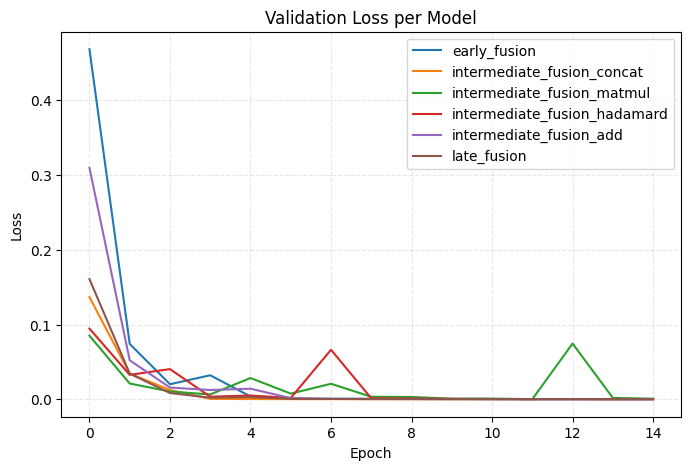

,Fusion Strategy,Avg Valid Loss,Best Valid Loss,Num of params,Avg time per epoch (min:s),"GPU Memory (MB, max)"
0,Early Fusion,0.040093,0.000051,8387990,4.824955,497.785156
1,Intermediate (Concat),0.012302,0.000011,16672374,8.649188,672.740723
2,Intermediate (Multiplicative),0.017621,0.000067,8480374,7.058182,643.093262
3,Intermediate (Hadamard),0.016501,0.000108,8480374,6.874232,675.445801
4,Intermediate (Add),0.027147,0.000060,8480374,6.826059,707.798340
5,Late Fusion,0.014009,0.000045,16672374,8.357273,833.400879


In [52]:
loss_dict = {name: m["valid_losses"] for name, m in metrics.items()}
plot_losses(loss_dict, title="Validation Loss per Model")

df_comparison = build_fusion_comparison_df(metrics, name_map)
df_comparison

In [53]:
# logs the comparison table to wandb
wandb.init(
    project="cilp-extended-assessment",   # your project name
    name="fusion_comparison_all",
    job_type="analysis",
)

fusion_comparison_table = wandb.Table(dataframe=df_comparison)
wandb.log({"fusion_comparison": fusion_comparison_table})

wandb.finish()

# Report (200-400 words)
*   Which architecture performed best and why
*   Trade-offs between parameter count and performance
* Recommendations for when to use each approach


Trade-offs between parameter count and performance

* Übersicht in metrics table
* Performance ist Geschwindigkeit oder finaler Outcome gemeint?

**When to use**

**Early Fusion:**
* Aligned, closely related low-level modalities and comparable features
* Simple setup; avoid if sensors are noisy

**Intermediate Fusion:**
* Modalities with different structure that benefit from separate early processing in order to learn modality-specific features   
* best overall balance of performance and flexibility

**Late Fusion:**
* Strong, independent unimodal predictors, to combine their strengths
* ideal for heterogeneous or missing modalities
* robust fallback when one modality fails